In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import enterprise_extensions
from enterprise_extensions import models, sampler

In [2]:
# import the par and tim files
datadir = './fakes'

parfiles = sorted(glob.glob(datadir + '/par/' + '*.par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + '*.tim'))

psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem='DE438')
    psrs.append(psr)

In [3]:
for psr in psrs:
    print(psr.name)

B1855+09
B1937+21
B1953+29
J0030+0451
J0613-0200
J1012+5307
J1024-0719
J1455-3330
J1600-3053
J1614-2230
J1640+2224
J1643-1224
J1713+0747
J1738+0333
J1741+1351
J1744-1134
J1903+0327
J1909-3744
J1910+1256
J1918-0642
J2010-1323
J2145-0750
J2317+1439


In [102]:
names_list = []
for psr in psrs:
    names_list.append(psr.name)

# names = ['J1909-3744', 'J2317+1439', 'J1600-3053', 'J1918-0642']
# names = ['J1909-3744', 'J2317+1439', 'J1600-3053', 'J1918-0642', 'J0613-0200', 'J1744-1134', 'J1910+1256']
names = ['J2317+1439', 'J1640+2224', 'J1614-2230']

psrs_cut = []
for name in names:
    psrs_cut.append(psrs[names_list.index(name)])
print(psrs_cut)

for psr in psrs_cut:
    print(psr.name)

[<enterprise.pulsar.Tempo2Pulsar object at 0x7fddd48c9a30>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddd2431cd0>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddd48d1f40>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddd48c98b0>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddcf601550>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddd48d1d00>, <enterprise.pulsar.Tempo2Pulsar object at 0x7fddd48c98e0>]
J1909-3744
J2317+1439
J1600-3053
J1918-0642
J0613-0200
J1744-1134
J1910+1256


In [103]:
# # for psr in psrs:
# #     print(psr.name)
# num_psrs = 1
# psrs_cut = psrs[0:num_psrs]
# print(len(psrs_cut))
# for psr in psrs_cut:
#     print(psr.name)

In [104]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs_cut]
tmax = [p.toas.max() for p in psrs_cut]
Tspan = np.max(tmax) - np.min(tmin)

In [105]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

In [106]:
# white noise parameters
# we set these ourselves so we know the most likely values!
efac = parameter.Constant(1)
equad = parameter.Constant(0)
ecorr = parameter.Constant(0)

# red noise parameters
log10_A = parameter.LinearExp(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

In [107]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd=True) # stabilizing timing model design matrix with SVD

In [108]:
s = ef + rn + gw + tm

In [109]:


# make a list of names to search through
psrs_names = []
for psr in psrs:
    psrs_names.append(psr.name)

# J1909_ind = psrs_names.index('J1909-3744')
# J1713_ind = psrs_names.index('J1713+0747')
# J1744_ind = psrs_names.index('J1744-1134')

# psrs_cut = [psrs[J1909_ind], psrs[J1713_ind], psrs[J1744_ind]]
# intialize PTA
models = []

for p in psrs_cut:
    models.append(s(p))

pta = signal_base.PTA(models)

In [110]:
print(pta.params)

[J0613-0200_red_noise_gamma:Uniform(pmin=0, pmax=7), J0613-0200_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J1600-3053_red_noise_gamma:Uniform(pmin=0, pmax=7), J1600-3053_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J1744-1134_red_noise_gamma:Uniform(pmin=0, pmax=7), J1744-1134_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7), J1909-3744_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J1910+1256_red_noise_gamma:Uniform(pmin=0, pmax=7), J1910+1256_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J1918-0642_red_noise_gamma:Uniform(pmin=0, pmax=7), J1918-0642_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), J2317+1439_red_noise_gamma:Uniform(pmin=0, pmax=7), J2317+1439_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), log10_A_gw:LinearExp(pmin=-18, pmax=-12)]


In [111]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [112]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = os.path.join(os.getcwd(), 'chains_pta_test')

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=False)

In [113]:
# sampler for N steps
N = int(7e5)  # normally, we would use 5e6 samples (this will save time)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 1.43 percent in 69.233991 s Acceptance rate = 0.45Adding DE jump with weight 50
Finished 99.86 percent in 4760.737121 s Acceptance rate = 0.269266
Run Complete


In [114]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])

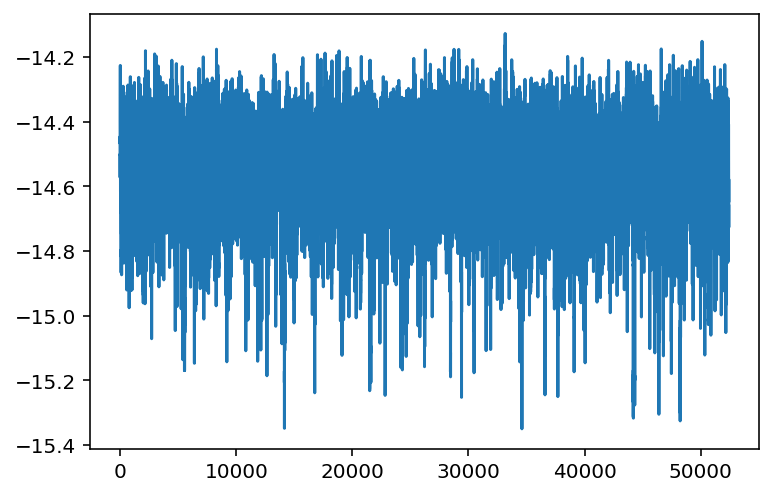

In [115]:
ind = list(pta.param_names).index('log10_A_gw')
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

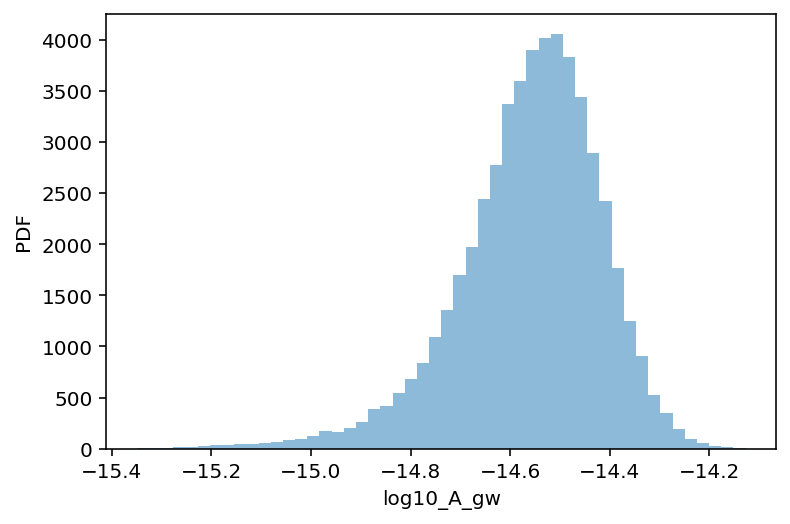

In [116]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')

In [117]:
upper = 10**np.percentile(chain[burn:, ind], q=95)
print(pta.param_names)
print(ind)
print(psrs[0].name)
print(upper)

['J0613-0200_red_noise_gamma', 'J0613-0200_red_noise_log10_A', 'J1600-3053_red_noise_gamma', 'J1600-3053_red_noise_log10_A', 'J1744-1134_red_noise_gamma', 'J1744-1134_red_noise_log10_A', 'J1909-3744_red_noise_gamma', 'J1909-3744_red_noise_log10_A', 'J1910+1256_red_noise_gamma', 'J1910+1256_red_noise_log10_A', 'J1918-0642_red_noise_gamma', 'J1918-0642_red_noise_log10_A', 'J2317+1439_red_noise_gamma', 'J2317+1439_red_noise_log10_A', 'log10_A_gw']
14
B1855+09
4.401116431640455e-15


In [66]:
# Make 2d histogram plot for white noise
# ind_end = len(pta.params)
# fig = corner.corner(chain[burn:, np.arange(ind_end)],
#                     labels=list(pta.param_names[0:ind_end]), label_kwargs={"fontsize": 7},
#                     levels=[0.68,0.95]);

In [68]:
pta.params

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 B1937+21_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1937+21_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 B1953+29_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1953+29_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0030+0451_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 log10_A_gw:LinearExp(pmin=-18, pmax=-12)]